In [ ]:
#@title Set up googlemaps.
GMAPS_API_KEY = ''  #@param {'type': 'string'}
! pip install -U googlemaps
import googlemaps
gmaps = googlemaps.Client(key=GMAPS_API_KEY)

In [2]:
#@title Imports & constants.
import cv2
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from tqdm.notebook import tqdm

from google.colab.patches import cv2_imshow

SQUERRYES_LOC = np.array([51.275982, 0.086721])
CHURCHMEAD_LOC = np.array([51.66714, -0.614273])

In [4]:
#@title Load images.
! curl -s https://raw.githubusercontent.com/jperlin/time-to-parkrun/main/filter2.png --output filter2.png
! curl -s https://raw.githubusercontent.com/jperlin/time-to-parkrun/main/london-map-screenshot.png --output london-map-screenshot.png

map_image = cv2.imread('london-map-screenshot.png')
filter = cv2.imread('filter2.png')
print(f'{map_image.shape=}, {filter.shape=}')

print('\nThe filter:')
cv2_imshow(filter)

map_image.shape=(711, 897, 3), filter.shape=(25, 15, 3)

The filter:


d.shape=(687, 883)
Found 84 parkruns.


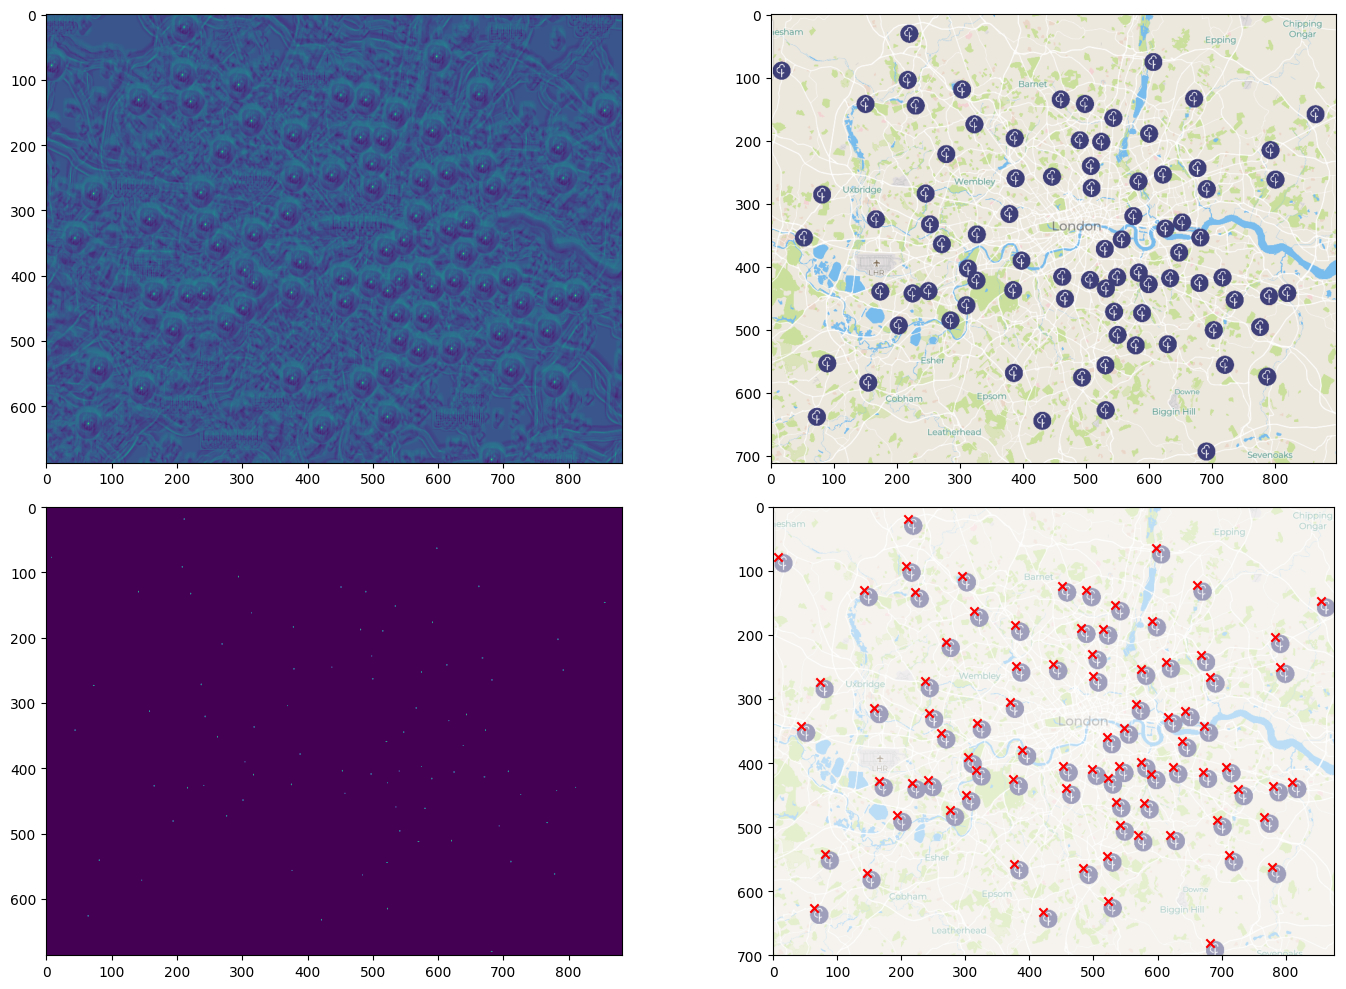

In [5]:
#@title Detect parkrun icons and map to latlong coordinates.

d = cv2.matchTemplate(map_image, filter, cv2.TM_CCOEFF_NORMED)
print(f'{d.shape=}')

# Empirical.
ICON_DETECTION_THRESH = 0.65  #@param {'type': 'number'}
sets = []

for idx in np.argwhere(d > ICON_DETECTION_THRESH):
  tidx = tuple(idx)
  neis = {
      tuple(idx - np.array([dx,dy]))
      for dx, dy in itertools.product(range(-2,3,1), range(-2,3,1))
  }
  for s in sets:
    if any(nei in s for nei in neis):
      s.add(tidx)
      break
  else:
    sets.append({tidx})

def get_median(s):
  xs, ys = [], []
  for t in s:
    xs.append(t[0])
    ys.append(t[1])
  return (np.median(xs), np.median(ys))

centres = [get_median(s) for s in sets]
sorted_by_distance_to_top_left_corner = sorted(
    centres, key=lambda x: np.linalg.norm(np.array(x)))

top_left = np.array(sorted_by_distance_to_top_left_corner[0])
bot_righ = np.array(sorted_by_distance_to_top_left_corner[-1])
# print(f'Top-left (Church Mead): {top_left}')
# print(f'Bottom-right (Squerryes Winery): {bot_righ}')

def pixel_to_coords(px: tuple[int,int]) -> np.ndarray:
  px = np.array(px, dtype=np.float64)
  frac = (px - top_left) / (bot_righ - top_left)
  return CHURCHMEAD_LOC + frac * (SQUERRYES_LOC - CHURCHMEAD_LOC)

parkruns = [pixel_to_coords(px) for px in sorted_by_distance_to_top_left_corner]
print(f'Found {len(parkruns)} parkruns.')

# Visualise the process.

fig, axs = plt.subplots(2, 2, figsize=(15, 10)); axs = axs.flatten()
axs[0].imshow(d)
axs[1].imshow(map_image @ [[0,0,1],[0,1,0],[1,0,0]])
axs[2].imshow(d > ICON_DETECTION_THRESH)

ax = axs[3]
ax.imshow(map_image @ [[0,0,1],[0,1,0],[1,0,0]], alpha=0.5)
ax.set_aspect(axs[1].get_aspect())
ax.set_xlim((0, 875))
ax.set_ylim((700, 0))
for parkrun in sorted_by_distance_to_top_left_corner:
  ax.scatter(parkrun[1], parkrun[0], c='red', marker='x')
fig.tight_layout()

In [6]:
#@title `def send_request`
def send_request(start_loc, latlng):
  response = gmaps.directions(
    origin=start_location,
    destination=f'{float(latlng[0])},{float(latlng[1])}',
    mode='transit',
    arrival_time=datetime.datetime(2023, 11, 4,
                                   8, 40),
  )
  assert len(response) == len(response[0]['legs']) == 1
  response_leg_0 = response[0]['legs'][0]
  duration_secs = response_leg_0['duration']['value']
  end_address = response_leg_0['end_address']
  end_latlng = response_leg_0['end_location']
  return duration_secs, end_address, end_latlng, response

In [10]:
#@title Get results for King's Cross.
start_location = "King's Cross, London"  #@param {'type': 'string'}
results = []
for parkrun in tqdm(parkruns):
  results.append(send_request(start_loc=start_location, latlng=parkrun))

  0%|          | 0/84 [00:00<?, ?it/s]

In [11]:
#@title Pretty-print results.
for r in sorted(results):
  print(f"{r[0]/60:.0f}min\t({r[2]['lat']:.7f}, {r[2]['lng']:.7f})  \t{r[1]}")

12min	(51.5465046, -0.1030516)  	1 Highbury Pl, London N5 1QZ, UK
22min	(51.5691850, -0.1042017)  	Capital Ring, Finsbury Park, London N4 3EY, UK
29min	(51.5581807, -0.1677256)  	Unnamed Road, London NW3 2SN, UK
35min	(51.5532936, -0.0252034)  	Unnamed Road, London E9 5EF, UK
36min	(51.4522343, -0.1057632)  	Unnamed Road, London SE24 0PA, UK
37min	(51.5941480, -0.0865738)  	Unnamed Road, London N17, UK
38min	(51.5952390, -0.1219013)  	Alexandra Palace Way, London N22 7BD, UK
39min	(51.4555104, -0.1510652)  	A205, London SW4 9AN, UK
39min	(51.5565121, -0.2280106)  	Lecky House, 66 Oman Ave, London NW2 6BD, UK
42min	(51.5176621, -0.0334559)  	St Paul's Way, London E14 7SU, UK
44min	(51.4841424, -0.0808244)  	Unnamed Road, London SE5 0JE, UK
44min	(51.5049686, 0.0185587)  	28 Fitzwilliam Mews, London E16 1SD, UK
45min	(51.4939977, -0.0536727)  	49 Gomm Rd, London SE16 2TY, UK
46min	(51.6120295, -0.2956495)  	King George V Memorial Gardens, 110 Cheyneys Ave, Edgware HA8 6SE, UK
46min	(51.5